# S21 simulation of a resonator

Authors: Sara Buhktari, Christian Kraglund Andersen


In [1]:
# Import useful packages
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict

# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

# Packages for the simple design
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb_driven import LaunchpadWirebondDriven
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround

# Analysis
# from qiskit_metal.renderers.renderer_gds.gds_renderer import QGDSRenderer
# from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
from qiskit_metal.analyses.sweep_and_optimize.sweeping import Sweeping
import pyEPR as epr

# Set up the design

In [2]:
# Set up chip dimensions 
design = designs.DesignPlanar()
design._chips['main']['size']['size_x'] = '9mm'
design._chips['main']['size']['size_y'] = '9mm'

# Resonator and feedline gap width (W) and center conductor width (S) from reference 2
design.variables['cpw_width'] = '15 um' #S from reference 2
design.variables['cpw_gap'] = '9 um' #W from reference 2


design.overwrite_enabled = True

hfss = design.renderers.hfss

# Open GUI
gui = MetalGUI(design)

In [3]:
# Define for renderer
eig_qres = EPRanalysis(design, "hfss")
hfss = design.renderers.hfss
hfss = eig_qres.sim.renderer
q3d = design.renderers.q3d

# Define the geometry

Here we will have a single feedline couple to a single CPW resonator.

The lauchpad should be included in the driven model simulations.

For that reason, we use the LaunchpadWirebondDriven component which has an extra pin for input/output

In [6]:
###################
# Single feedline #
###################

# Driven Lauchpad 1
x = '-2.5mm'
y = '2.0mm'
launch_options = dict(chip='main', pos_x=x, pos_y=y, orientation='360', lead_length='30um', 
                    pad_width='323.78um', pad_height='172.77um', pad_gap='242.288um', taper_height='571.32um')
LP1 = LaunchpadWirebondDriven(design, 'LP1', options = launch_options)

# Driven Launchpad 2
x = '2.5mm'
y = '2.0mm'
launch_options = dict(chip='main', pos_x=x, pos_y=y, orientation='180', lead_length='30um',
                    pad_width='323.78um', pad_height='172.77um', pad_gap='242.288um', taper_height='571.32um')
LP2 = LaunchpadWirebondDriven(design, 'LP2', options = launch_options)

# Using path finder to connect the two launchpads
TL_LP1_LP2 = RoutePathfinder(design, 'TL_LP1_LP2', options = dict(chip='main', 
                                            trace_width ='12um',
                                            trace_gap ='7.2um',
                                            fillet='75um',                 
                                            hfss_wire_bonds = False,
                                            lead=dict(end_straight='1.972mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))


# Rebuild the GUI
gui.rebuild()


In [ ]:
######################
# lambda/2 resonator #
######################

# First we define the two end-points
otg1 = OpenToGround(design, 'otg1s', options=dict(chip='main', pos_x='0.8mm',  pos_y='1.975mm', orientation='180'))
otg2 = OpenToGround(design, 'otg1e', options=dict(chip='main', pos_x='1.2mm',  pos_y='0.4mm', orientation='270'))

# Use RouteMeander to fix the total length of the resonator
rt_meander1 = RouteMeander(design, 'meander1',  Dict(
        trace_width ='9.6um',
        trace_gap ='4um',
        total_length='4.785mm',
        hfss_wire_bonds = False,
        fillet='75 um',
        lead = dict(start_straight='347um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg1s', pin='open'),
            end_pin=Dict(component='otg1e', pin='open')), ))


# First we define the two end-points
otg3 = OpenToGround(design, 'otg2s', options=dict(chip='main', pos_x='-1.2mm',  pos_y='1.975mm', orientation='180'))
otg4 = OpenToGround(design, 'otg2e', options=dict(chip='main', pos_x='-0.8mm',  pos_y='-0.9mm', orientation='270'))

# Use RouteMeander to fix the total length of the resonator
rt_meander2 = RouteMeander(design, 'meander2',  Dict(
        trace_width ='9.6um',
        trace_gap ='4um',
        total_length='12.228mm',
        hfss_wire_bonds = False,
        fillet='75 um',
        lead = dict(start_straight='447um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg2s', pin='open'),
            end_pin=Dict(component='otg2e', pin='open')), ))

# rebuild the GUI
gui.rebuild()
gui.autoscale()

02:40PM 50s WARNING [add_pins_to_table]: Component: 19 and pin: open are already in net_info with net_id 25
02:40PM 50s WARNING [connect_pins]: NetId was not added for 19, open, 9, start and will not be added to components.
02:40PM 50s WARNING [add_pins_to_table]: Component: 20 and pin: open are already in net_info with net_id 26
02:40PM 50s WARNING [connect_pins]: NetId was not added for 20, open, 9, end and will not be added to components.


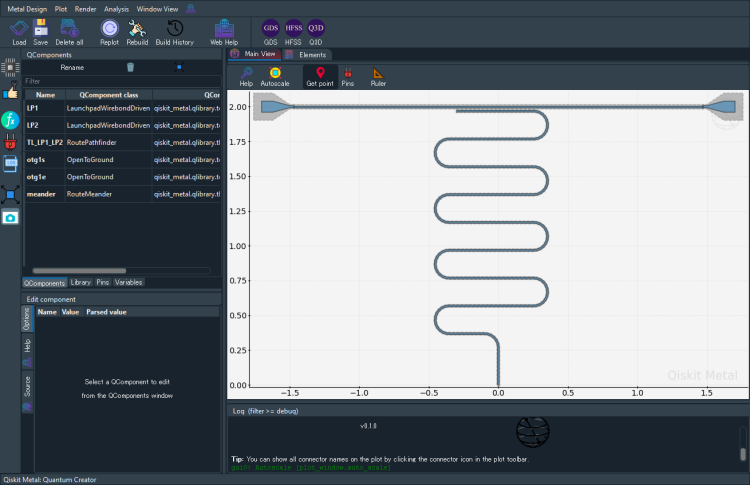

In [6]:
gui.screenshot()

# Scattering Analysis

In [7]:
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
em1 = ScatteringImpedanceSim(design, "hfss")

In [8]:
design_name= "Sweep_DrivenModal"
qcomp_render = [] # Means to render everything in qgeometry table.
open_terminations = []

# Here, pin LP1_in and LP2_in are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('LP1', 'in', 50),
             ('LP2', 'in', 50)]
box_plus_buffer = True

In [9]:
# we use HFSS as rendere
hfss = em1.renderer
hfss.start()

INFO 01:53PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:53PM [load_ansys_project]: 	Opened Ansys App
INFO 01:53PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 01:53PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/chen/Documents/Ansoft/
	Project:   Project10
INFO 01:53PM [connect_design]: No active design found (or error getting active design).
INFO 01:53PM [connect]: 	 Connected to project "Project10". No design detected


True

In [10]:
# Here we activate the design for a drivenmodal solution
hfss.activate_ansys_design("HangingResonator", 'drivenmodal')
setup_args = Dict(max_delta_s=0.001)
setup_args.name = 'Setup'
hfss.edit_drivenmodal_setup(setup_args)

01:53PM 24s WARNING [activate_ansys_design]: The design_name=HangingResonator was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 01:53PM [connect_design]: 	Opened active design
	Design:    HangingResonator [Solution type: DrivenModal]
WARNING 01:53PM [connect_setup]: 	No design setup detected.
WARNING 01:53PM [connect_setup]: 	Creating drivenmodal default setup.
INFO 01:53PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
01:53PM 27s WARNING [edit_drivenmodal_setup]: In setup_args, key=max_delta_s, value=0.001 is not in pinfo.setup, the key/value pair from setup_args not added to Setup in Ansys.


In [11]:
# set buffer
hfss.options['x_buffer_width_mm'] = 0.1
hfss.options['y_buffer_width_mm'] = 0.1

In [12]:
# clean the design if needed
hfss.clean_active_design()

In [13]:
# render the design
hfss.render_design(selection=[], 
                   open_pins=open_terminations, 
                   port_list=port_list, 
                   box_plus_buffer = box_plus_buffer)

In [14]:
# for acurate simulations, make sure the mesh is fine enough for the meander
hfss.modeler.mesh_length(
                'cpw_mesh',
                ['trace_meander'],
                MaxLength='0.01mm')

# Broad sweet to find the resonance

In [15]:
hfss.add_sweep(setup_name="Setup", 
               name="Sweep", 
               start_ghz=4.0,
               stop_ghz=13.0,
               count=2001,
               type="Interpolating")

INFO 01:53PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


In [16]:
hfss.analyze_sweep('Sweep', 'Setup')

INFO 01:53PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 01:53PM [analyze]: Analyzing setup Setup : Sweep


In [17]:
hfss.plot_params(['S11', 'S21'])

(                      S11                 S21
 4.000 -0.033295-0.036933j -0.716856+0.695446j
 4.002 -0.033323-0.036936j -0.716588+0.695721j
 4.004 -0.033350-0.036940j -0.716319+0.695996j
 4.006 -0.033378-0.036944j -0.716051+0.696270j
 4.008 -0.033406-0.036947j -0.715782+0.696545j
 ...                   ...                 ...
 7.992 -0.077323-0.009452j -0.034497+0.996364j
 7.994 -0.077333-0.009425j -0.034114+0.996377j
 7.996 -0.077344-0.009398j -0.033731+0.996389j
 7.998 -0.077354-0.009371j -0.033347+0.996402j
 8.000 -0.077364-0.009344j -0.032964+0.996414j
 
 [2001 rows x 2 columns],
 <Figure size 1000x600 with 2 Axes>)

In [18]:
# extract the S21 parameters
freqs, Pcurves, Pparams = hfss.get_params(['S21'])

In [19]:
# find armin 
f_res = freqs[np.argmin(np.abs(Pparams.S21.values))]
f_res

7130000000.0

# Narrow sweep around the resonance found above

In [20]:
#fine sweep
hfss.add_sweep(setup_name="Setup", 
               name="Sweep_narrow", 
               start_ghz=np.round(f_res/1e9,3)-0.01,
               stop_ghz=np.round(f_res/1e9,3)+0.01,
               count=1001,
               type="Fast") #slow but precise

INFO 02:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


In [21]:
hfss.analyze_sweep('Sweep_narrow', 'Setup')

INFO 02:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 02:14PM [analyze]: Analyzing setup Setup : Sweep_narrow


In [22]:
hfss.plot_params(['S11', 'S21'])

(                        S11                 S21
 7.12000 -0.110844-0.014996j -0.161273+0.980551j
 7.12002 -0.110924-0.014982j -0.161190+0.980556j
 7.12004 -0.111005-0.014968j -0.161106+0.980560j
 7.12006 -0.111087-0.014953j -0.161021+0.980565j
 7.12008 -0.111169-0.014938j -0.160937+0.980570j
 ...                     ...                 ...
 7.13992 -0.035542-0.022337j -0.231149+0.972012j
 7.13994 -0.035613-0.022335j -0.231077+0.972027j
 7.13996 -0.035683-0.022332j -0.231005+0.972041j
 7.13998 -0.035754-0.022330j -0.230934+0.972056j
 7.14000 -0.035824-0.022328j -0.230863+0.972070j
 
 [1001 rows x 2 columns],
 <Figure size 1000x600 with 2 Axes>)

# Close connections

In [23]:
em1.close()

In [24]:
hfss.disconnect_ansys()

In [25]:
gui.main_window.close()

KeyboardInterrupt: 

02:19PM 40s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  WARNING: QWindowsNativeFileDialogBase::selectNameFilter: Invalid parameter '*.metal.py' not found in 'All Files (*)'.

02:19PM 40s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  WARNING: QWindowsNativeFileDialogBase::selectNameFilter: Invalid parameter '*.metal.py' not found in 'All Files (*)'.



True